In [1]:
import os
import nltk
import time
import datetime
import numpy as np
import scipy as sp
import pandas as pd

from itertools import product
from nltk.corpus import stopwords
from scipy.sparse import hstack

from sklearn.svm import SVC, SVR
from sklearn.metrics import classification_report, roc_curve, mean_squared_error, make_scorer, confusion_matrix
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, KFold, StratifiedKFold, validation_curve
from sklearn.feature_extraction import text

from utility.processing import *
from utility.utility import *

from imblearn.combine import *
from imblearn.over_sampling import *
from imblearn.under_sampling import * 
from imblearn.pipeline import Pipeline, make_pipeline

from joblib import Parallel, delayed
%matplotlib inline

# LSA

## 데이터 로드

In [4]:
train = pd.read_csv('./data/preprocessed_train.csv')
test = pd.read_csv('./data/preprocessed_test.csv')
idx = test.id.values.astype(int)
y = train.median_relevance.values

In [90]:
train, dev, y, y_dev = train_test_split(train, y, stratify=y, test_size=0.1)

In [91]:
train_query = list(train.apply(lambda x:'%s' % x['query_preprocessed'], axis=1))
train_title = list(train.apply(lambda x:'%s' % x['product_title_preprocessed'], axis=1))

dev_query = list(dev.apply(lambda x:'%s' % x['query_preprocessed'], axis=1))
dev_title = list(dev.apply(lambda x:'%s' % x['product_title_preprocessed'], axis=1))

test_query = list(test.apply(lambda x:'%s' % x['query_preprocessed'], axis=1))
test_title = list(test.apply(lambda x:'%s' % x['product_title_preprocessed'], axis=1))

## 모델링

### TF-IDF

In [92]:
# min_df=3 : 빈도수가 3번 이하인 단어 무시
# max_features=None : 단어 빈도수의 맥시멈 설정 x
# strip_accents='unicode' : 모든 특수문자와 pattern을 정재할수 없으므로 unicode사용
# analyzer='word' : corpus가 문장 list로 이루어져있어 단어단위로 분석
# token_pattern=r'\w{1,}' : analyzer == 'word'일 때 token_pattern을 기반으로 단어 인식
# ngram_range=(1, 3) : word window의 범위 1~3, 약 90% 쿼리가 word size 3이하로 이루어짐
# use_idf=True : idf사용
# smooth_idf=True : 분모가 0이 되는것을 방지
# sublinear_tf=True : 단어 스무딩, replace 1 + log(tf).
# stop_words : 불용어 제거
stop_words = text.ENGLISH_STOP_WORDS.union(['http', 'www', 'img', 'border', 'color', 'style', 'padding', 'table', 'font', '',
                                            'thi', 'inch', 'ha', 'width', 'height', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
stop_words = text.ENGLISH_STOP_WORDS.union(set(stopwords.words('english')))

tfv = text.TfidfVectorizer(min_df=7, max_features=None, strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
                           ngram_range=(1, 3), use_idf=True, smooth_idf=True, sublinear_tf=True,
                           stop_words=stop_words).fit(train_query + train_title)

X_train = hstack([tfv.transform(train_query), tfv.transform(train_title)])
X_dev = hstack([tfv.transform(dev_query), tfv.transform(dev_title)])
X_test = hstack([tfv.transform(test_query), tfv.transform(test_title)])

In [93]:
# 단어별 가중치 확인
# idf_dict = dict(zip(tfv.get_feature_names(), tfv.idf_))

### cos, jaccard similarlity

In [94]:
# query, title 유사도 계산(cos, jaccard)
sim = similarlity_stack()
X_sim_train = sim.fit_transform(X_train, y)
X_sim_dev = sim.transform(X_dev)
X_sim_test = sim.transform(X_test)

In [95]:
for i in range(1, 5):
    sims = X_sim_train.toarray()[np.where(y == i)].sum(axis=0)/len(np.where(y == i)[0])
    print("ratings %d \ncos_sim mean : %f\t jaccard_sim mean: %f\n" % (i, sims[0], sims[1]))

ratings 1 
cos_sim mean : 0.159919	 jaccard_sim mean: 0.106141

ratings 2 
cos_sim mean : 0.274563	 jaccard_sim mean: 0.188866

ratings 3 
cos_sim mean : 0.347661	 jaccard_sim mean: 0.242597

ratings 4 
cos_sim mean : 0.435886	 jaccard_sim mean: 0.311592



#### LogisticRegression

In [96]:
lr = LogisticRegression(max_iter=500)

X_train_sim = hstack([X_train, X_sim_train])
X_dev_sim = hstack([X_dev, X_sim_dev])

cv = StratifiedKFold(n_splits=5, shuffle=True)
kappa_scores = cross_val_score(lr, X_train, y, \
                               scoring=make_scorer(metric.quadratic_weighted_kappa, greater_is_better = True), cv=cv)
print("lr without sim kappa score 평균 : %0.2f, 편차 : %0.2f" % (np.mean(kappa_scores), np.std(kappa_scores)))

kappa_scores = cross_val_score(lr, X_train_sim, y, \
                               scoring=make_scorer(metric.quadratic_weighted_kappa, greater_is_better = True), cv=cv)
print("lr with sim kappa score 평균 : %0.2f, 편차 : %0.2f" % (np.mean(kappa_scores), np.std(kappa_scores)))

lr without sim kappa score 평균 : 0.50, 편차 : 0.02
lr with sim kappa score 평균 : 0.58, 편차 : 0.02


### LSA

In [97]:
# TruncatedSVD
# 261개의 쿼리이므로 n_components = 250로 모델링 시작
svd = TruncatedSVD(n_components = 250)
X_svd_train = svd.fit_transform(X_train)
X_svd_dev = svd.transform(X_dev)
X_svd_test = svd.transform(X_test)

In [98]:
# Truncated SVD와 유사도 hstack
X_stacked_train = hstack([X_svd_train, X_sim_train])
X_stacked_dev = hstack([X_svd_dev, X_sim_dev])
X_stacked_test = hstack([X_svd_test, X_sim_test])

In [99]:
# StandardScaler
# with_mean=False 행렬이 희소하고 [0,1]이므로 mean shift사용 X
scl = StandardScaler(with_mean=False)
X_scaled_train = scl.fit_transform(X_stacked_train)
X_scaled_dev = scl.transform(X_stacked_dev)
X_scaled_test = scl.transform(X_stacked_test)

In [31]:
for i in range(1, 5):
    sims = X_scaled_train[:,-2:].toarray()[np.where(y == i)].sum(axis=0)/len(np.where(y == i)[0])
    print("ratings %d \nscaled cos_sim mean : %f\t scaled jaccard_sim mean: %f\n" % (i, sims[0], sims[1]))

ratings 1 
scaled cos_sim mean : 0.671321	 scaled jaccard_sim mean: 0.523417

ratings 2 
scaled cos_sim mean : 1.114229	 scaled jaccard_sim mean: 0.894946

ratings 3 
scaled cos_sim mean : 1.386019	 scaled jaccard_sim mean: 1.123286

ratings 4 
scaled cos_sim mean : 1.756968	 scaled jaccard_sim mean: 1.444174



### classification(LogisticRegression)

In [14]:
lr = LogisticRegression(max_iter=500)

cv = StratifiedKFold(n_splits=5, shuffle=True)
kappa_scores = cross_val_score(lr, X_scaled_train, y, \
                               scoring=make_scorer(metric.quadratic_weighted_kappa, greater_is_better = True), cv=cv)

print("scaled lr kappa score 평균 : %0.2f, 편차 : %0.2f" % (np.mean(kappa_scores), np.std(kappa_scores)))

scaled lr without sim kappa score 평균 : 0.36, 편차 : 0.02
scaled lr with sim kappa score 평균 : 0.50, 편차 : 0.02


### classification(SVM)

In [15]:
# C=100(패널티) 문서당 유사도가 크기때문에(쿼리의 중복) 100으로 잡고 시작
svm = SVC(C = 100, gamma='auto', probability=True)

cv = StratifiedKFold(n_splits=5, shuffle=True)
kappa_scores = cross_val_score(svm, X_scaled_train, y, \
                               scoring=make_scorer(metric.quadratic_weighted_kappa, greater_is_better = True), cv=cv)
print("svm kappa score 평균 : %0.2f, 편차 : %0.2f" % (np.mean(kappa_scores), np.std(kappa_scores)))

svm without sim kappa score 평균 : 0.62, 편차 : 0.01
svm with sim kappa score 평균 : 0.62, 편차 : 0.01


## 모델링 결과 해석

kappa
train : 0.901398	dev : 0.614689
rmse
train : 0.434132	dev : 0.848226

confusion_matrix : 1016개중 346개를 틀림
 [[ 35  29   3  10]
 [ 10  68  28  42]
 [ 10  28  43  93]
 [  4  36  53 524]]

classification_report :
               precision    recall  f1-score   support

           1       0.59      0.45      0.51        77
           2       0.42      0.46      0.44       148
           3       0.34      0.25      0.29       174
           4       0.78      0.85      0.81       617

    accuracy                           0.66      1016
   macro avg       0.53      0.50      0.51      1016
weighted avg       0.64      0.66      0.65      1016



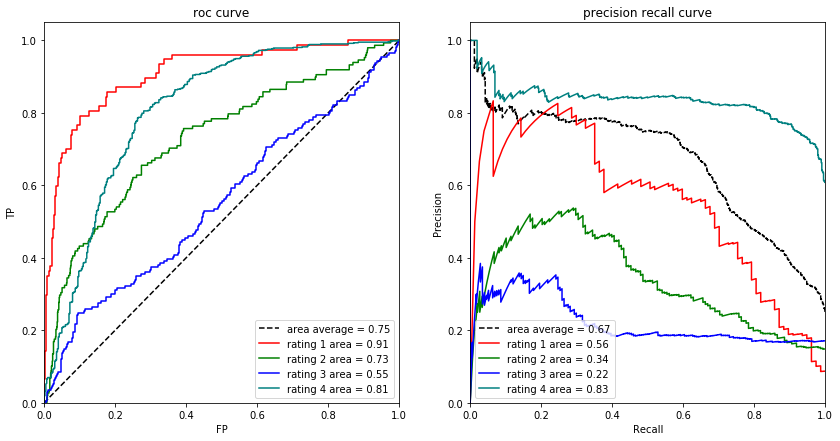

In [15]:
svm_result = svm.fit(X_scaled_train, y)
svm_pred_train = svm_result.predict(X_scaled_train)
svm_pred_dev = svm_result.predict(X_scaled_dev)

print("kappa\ntrain : %f\tdev : %f"% (metric.quadratic_weighted_kappa(y, svm_pred_train), \
                                      metric.quadratic_weighted_kappa(y_dev, svm_pred_dev)))

print("rmse\ntrain : %f\tdev : %f"% (mean_squared_error(y, svm_pred_train)**0.5, \
                                     mean_squared_error(y_dev, svm_pred_dev)**0.5))

print('\nconfusion_matrix : %d개중 %d개를 틀림\n'%(len(y_dev), len(np.where(svm_pred_dev!=y_dev)[0])), \
      confusion_matrix(y_dev, svm_pred_dev))
print('\nclassification_report :\n', classification_report(y_dev, svm_pred_dev))

plot_multiclass_roc_prc(svm, X_scaled_dev, y_dev)

## 개선된 모델

sampling finish
fitting finish
kappa
train : 0.969111	dev : 0.636662
rmse
train : 0.278571	dev : 0.836542

confusion_matrix : 1016개중 352개를 틀림
 [[ 47  21   4   5]
 [ 10  71  27  40]
 [  9  35  43  87]
 [  5  40  69 503]]

classification_report :
               precision    recall  f1-score   support

           1       0.66      0.61      0.64        77
           2       0.43      0.48      0.45       148
           3       0.30      0.25      0.27       174
           4       0.79      0.82      0.80       617

    accuracy                           0.65      1016
   macro avg       0.54      0.54      0.54      1016
weighted avg       0.64      0.65      0.65      1016



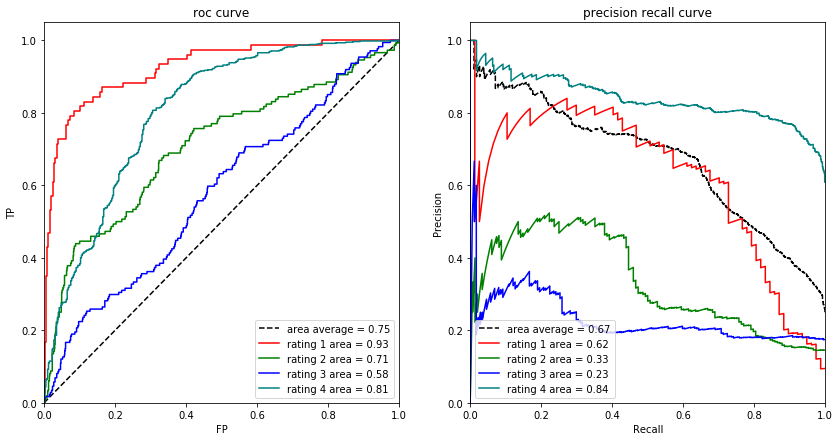

In [61]:
svmsmote = SVMSMOTE(sampling_strategy='not majority', k_neighbors=4, svm_estimator=SVC(C=50), n_jobs=-1)
X_samp, y_samp = svmsmote.fit_sample(X_scaled_train, y)
print('sampling finish')
svm = SVC(C=50, probability=True)
svmresult = svm.fit(X_samp, y_samp)
print('fitting finish')
svmpredtrain = svmresult.predict(X_samp)
svmpreddev = svmresult.predict(X_scaled_dev)

print("kappa\ntrain : %f\tdev : %f"% (metric.quadratic_weighted_kappa(y_samp, svmpredtrain), \
                                      metric.quadratic_weighted_kappa(y_dev, svmpreddev)))

print("rmse\ntrain : %f\tdev : %f"% (mean_squared_error(y_samp, svmpredtrain)**0.5, \
                                     mean_squared_error(y_dev, svmpreddev)**0.5))

print('\nconfusion_matrix : %d개중 %d개를 틀림\n'%(len(y_dev), len(np.where(svmpreddev!=y_dev)[0])), \
      confusion_matrix(y_dev, svmpreddev))
print('\nclassification_report :\n', classification_report(y_dev, svmpreddev))

plot_multiclass_roc_prc(svmresult, X_scaled_dev, y_dev)

sampling finish
fitting finish
kappa
train : 0.929231	dev : 0.651356
rmse
train : 0.422783	dev : 0.816898

confusion_matrix : 1016개중 345개를 틀림
 [[ 49  20   3   5]
 [ 13  68  31  36]
 [  6  29  59  80]
 [  7  34  81 495]]

classification_report :
               precision    recall  f1-score   support

           1       0.65      0.64      0.64        77
           2       0.45      0.46      0.45       148
           3       0.34      0.34      0.34       174
           4       0.80      0.80      0.80       617

    accuracy                           0.66      1016
   macro avg       0.56      0.56      0.56      1016
weighted avg       0.66      0.66      0.66      1016



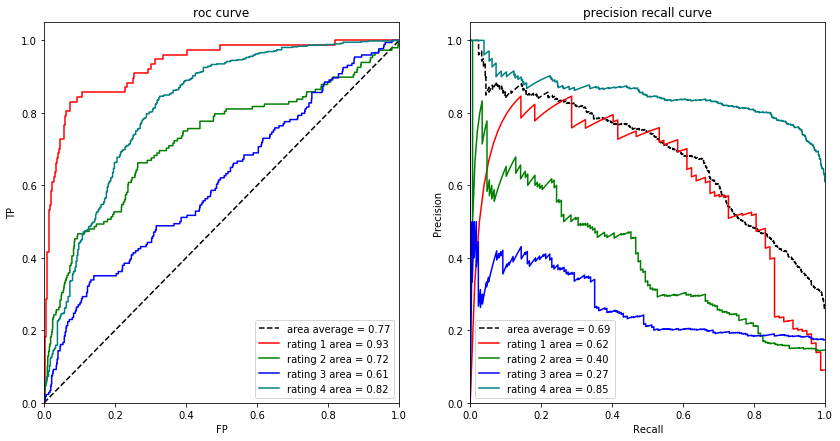

In [66]:
svmsmote = SVMSMOTE(sampling_strategy='not majority', k_neighbors=4, svm_estimator=SVC(C=10), n_jobs=-1)
X_samp, y_samp = svmsmote.fit_sample(X_scaled_train, y)
print('sampling finish')
svm = SVC(C=10, probability=True)
svmresult = svm.fit(X_samp, y_samp)
print('fitting finish')
svmpredtrain = svmresult.predict(X_samp)
svmpreddev = svmresult.predict(X_scaled_dev)

print("kappa\ntrain : %f\tdev : %f"% (metric.quadratic_weighted_kappa(y_samp, svmpredtrain), \
                                      metric.quadratic_weighted_kappa(y_dev, svmpreddev)))

print("rmse\ntrain : %f\tdev : %f"% (mean_squared_error(y_samp, svmpredtrain)**0.5, \
                                     mean_squared_error(y_dev, svmpreddev)**0.5))

print('\nconfusion_matrix : %d개중 %d개를 틀림\n'%(len(y_dev), len(np.where(svmpreddev!=y_dev)[0])), \
      confusion_matrix(y_dev, svmpreddev))
print('\nclassification_report :\n', classification_report(y_dev, svmpreddev))

plot_multiclass_roc_prc(svmresult, X_scaled_dev, y_dev)

sampling finish
fitting finish
kappa
train : 0.918276	dev : 0.640076
rmse
train : 0.455283	dev : 0.837718

confusion_matrix : 1016개중 341개를 틀림
 [[ 47  23   3   4]
 [ 11  74  25  38]
 [  7  37  51  79]
 [  8  44  62 503]]

classification_report :
               precision    recall  f1-score   support

           1       0.64      0.61      0.63        77
           2       0.42      0.50      0.45       148
           3       0.36      0.29      0.32       174
           4       0.81      0.82      0.81       617

    accuracy                           0.66      1016
   macro avg       0.56      0.55      0.55      1016
weighted avg       0.66      0.66      0.66      1016



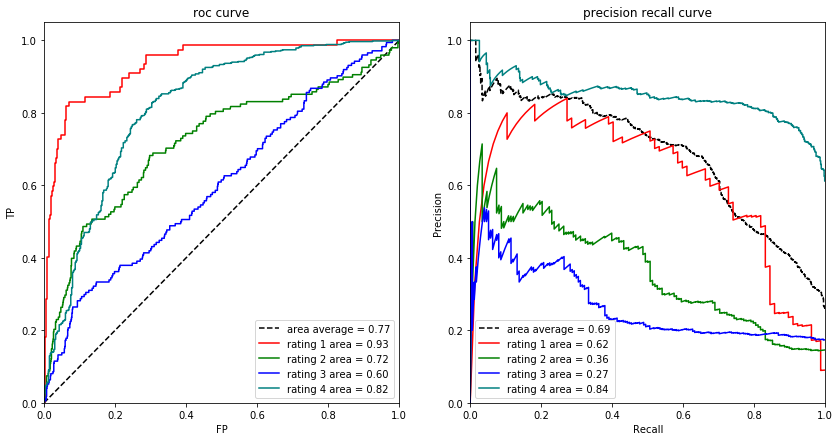

In [67]:
svmsmote = SVMSMOTE(sampling_strategy='not majority', k_neighbors=4, svm_estimator=SVC(C=8), n_jobs=-1)
X_samp, y_samp = svmsmote.fit_sample(X_scaled_train, y)
print('sampling finish')
svm = SVC(C=8, probability=True)
svmresult = svm.fit(X_samp, y_samp)
print('fitting finish')
svmpredtrain = svmresult.predict(X_samp)
svmpreddev = svmresult.predict(X_scaled_dev)

print("kappa\ntrain : %f\tdev : %f"% (metric.quadratic_weighted_kappa(y_samp, svmpredtrain), \
                                      metric.quadratic_weighted_kappa(y_dev, svmpreddev)))

print("rmse\ntrain : %f\tdev : %f"% (mean_squared_error(y_samp, svmpredtrain)**0.5, \
                                     mean_squared_error(y_dev, svmpreddev)**0.5))

print('\nconfusion_matrix : %d개중 %d개를 틀림\n'%(len(y_dev), len(np.where(svmpreddev!=y_dev)[0])), \
      confusion_matrix(y_dev, svmpreddev))
print('\nclassification_report :\n', classification_report(y_dev, svmpreddev))

plot_multiclass_roc_prc(svmresult, X_scaled_dev, y_dev)

sampling finish
fitting finish
kappa
train : 0.904932	dev : 0.649955
rmse
train : 0.490089	dev : 0.827076

confusion_matrix : 1016개중 340개를 틀림
 [[ 49  21   3   4]
 [ 16  67  29  36]
 [  7  31  61  75]
 [ 10  35  73 499]]

classification_report :
               precision    recall  f1-score   support

           1       0.60      0.64      0.62        77
           2       0.44      0.45      0.44       148
           3       0.37      0.35      0.36       174
           4       0.81      0.81      0.81       617

    accuracy                           0.67      1016
   macro avg       0.55      0.56      0.56      1016
weighted avg       0.67      0.67      0.67      1016



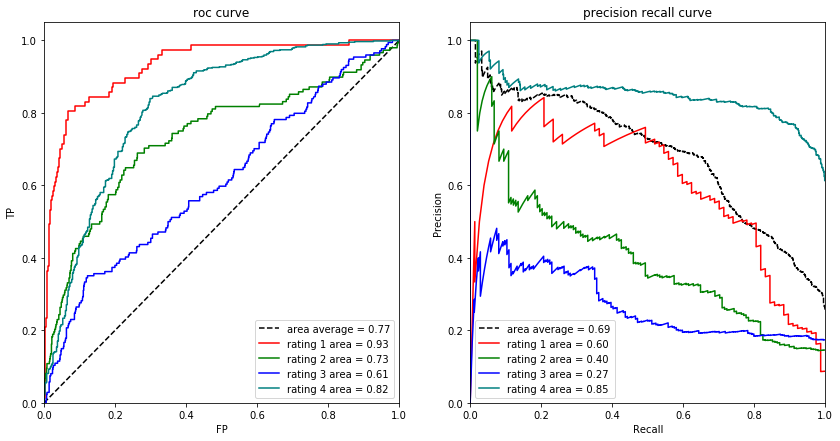

In [64]:
svmsmote = SVMSMOTE(sampling_strategy='not majority', k_neighbors=4, svm_estimator=SVC(C=5), n_jobs=-1)
X_samp, y_samp = svmsmote.fit_sample(X_scaled_train, y)
print('sampling finish')
svm = SVC(C=5, probability=True)
svmresult = svm.fit(X_samp, y_samp)
print('fitting finish')
svmpredtrain = svmresult.predict(X_samp)
svmpreddev = svmresult.predict(X_scaled_dev)

print("kappa\ntrain : %f\tdev : %f"% (metric.quadratic_weighted_kappa(y_samp, svmpredtrain), \
                                      metric.quadratic_weighted_kappa(y_dev, svmpreddev)))

print("rmse\ntrain : %f\tdev : %f"% (mean_squared_error(y_samp, svmpredtrain)**0.5, \
                                     mean_squared_error(y_dev, svmpreddev)**0.5))

print('\nconfusion_matrix : %d개중 %d개를 틀림\n'%(len(y_dev), len(np.where(svmpreddev!=y_dev)[0])), \
      confusion_matrix(y_dev, svmpreddev))
print('\nclassification_report :\n', classification_report(y_dev, svmpreddev))

plot_multiclass_roc_prc(svmresult, X_scaled_dev, y_dev)

sampling finish
fitting finish
kappa
train : 0.884493	dev : 0.651416
rmse
train : 0.544971	dev : 0.834776

confusion_matrix : 1016개중 324개를 틀림
 [[ 51  20   2   4]
 [ 15  73  23  37]
 [  7  36  53  78]
 [ 11  42  49 515]]

classification_report :
               precision    recall  f1-score   support

           1       0.61      0.66      0.63        77
           2       0.43      0.49      0.46       148
           3       0.42      0.30      0.35       174
           4       0.81      0.83      0.82       617

    accuracy                           0.68      1016
   macro avg       0.57      0.57      0.57      1016
weighted avg       0.67      0.68      0.67      1016



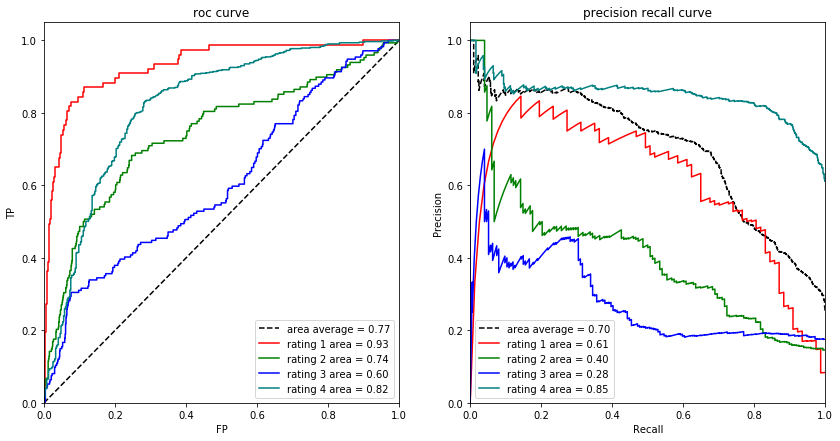

In [86]:
svmsmote = SVMSMOTE(sampling_strategy='not majority', k_neighbors=4, svm_estimator=SVC(C=3), n_jobs=-1)
X_samp, y_samp = svmsmote.fit_sample(X_scaled_train, y)
print('sampling finish')
svm = SVC(C=3, probability=True)
svmresult = svm.fit(X_samp, y_samp)
print('fitting finish')
svmpredtrain = svmresult.predict(X_samp)
svmpreddev = svmresult.predict(X_scaled_dev)

print("kappa\ntrain : %f\tdev : %f"% (metric.quadratic_weighted_kappa(y_samp, svmpredtrain), \
                                      metric.quadratic_weighted_kappa(y_dev, svmpreddev)))

print("rmse\ntrain : %f\tdev : %f"% (mean_squared_error(y_samp, svmpredtrain)**0.5, \
                                     mean_squared_error(y_dev, svmpreddev)**0.5))

print('\nconfusion_matrix : %d개중 %d개를 틀림\n'%(len(y_dev), len(np.where(svmpreddev!=y_dev)[0])), \
      confusion_matrix(y_dev, svmpreddev))
print('\nclassification_report :\n', classification_report(y_dev, svmpreddev))

plot_multiclass_roc_prc(svmresult, X_scaled_dev, y_dev)

#### SVMSMOTE find k_neighbors

In [31]:
from sklearn.base import clone

In [37]:
def _svm_smote(svm, smt, X, Y, train_index, test_index):
    print('sampling start')
    X_samp, y_samp = smt.fit_sample(X[train_index], Y[train_index])
    svm_result = svm.fit(X_samp, y_samp)
    svm_pred_dev = svm_result.predict(X[test_index])
    svm_pred_proba_dev = svm_result.predict_proba(X[test_index])
    print('end')
    return metric.quadratic_weighted_kappa(Y[test_index], svm_pred_dev), metric.pr_auc_score(Y[test_index], svm_pred_proba_dev)

In [38]:
_k_fold = StratifiedKFold(n_splits=4, shuffle=True)
parallel = Parallel(n_jobs=2)

svm = SVC(C=100, gamma='auto', psobability=True)
scores_list = []
for k in range(1, 11):
    smt = SVMSMOTE(sampling_strategy='not majority', svm_estimator=SVC(C=100, gamma='auto'), n_jobs=2, k_neighbors=k)
    scores = parallel(
        delayed(_svm_smote)(clone(svm), clone(smt), X_scaled_train, y, train_index, test_index) 
        for train_index, test_index in _k_fold.split(X_scaled_train, y)
    )
    scores_list.append(scores)

In [42]:
kappa_test_scores_mean, kappa_test_scores_std, auc_test_scores_mean,auc_test_scores_std = [], [], [], []
for score_static in scores_list:
    kappa_test_scores_mean.append(np.mean(score_static, axis=0)[0])
    kappa_test_scores_std.append(np.std(score_static, axis=0)[0])
    auc_test_scores_mean.append(np.mean(score_static, axis=0)[1])
    auc_test_scores_std.append(np.std(score_static, axis=0)[1])
kappa_test_scores_mean = np.array(kappa_test_scores_mean)
kappa_test_scores_std = np.array(kappa_test_scores_std)
auc_test_scores_mean = np.array(auc_test_scores_mean)
auc_test_scores_std = np.array(auc_test_scores_std)

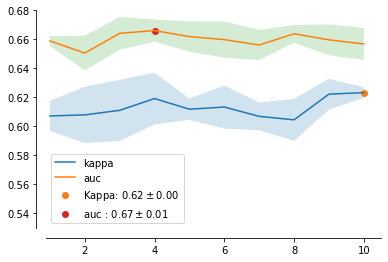

In [60]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

param_range = range(1, 11)
plt.plot(param_range, kappa_test_scores_mean, label='kappa')
ax.fill_between(param_range, kappa_test_scores_mean + kappa_test_scores_std,
                kappa_test_scores_mean - kappa_test_scores_std, alpha=0.2)
kappa_idx_max = np.argmax(kappa_test_scores_mean)
plt.scatter(param_range[kappa_idx_max], kappa_test_scores_mean[kappa_idx_max],
            label=r'Kappa: ${:.2f}\pm{:.2f}$'.format(kappa_test_scores_mean[kappa_idx_max], kappa_test_scores_std[kappa_idx_max]))


plt.plot(param_range, auc_test_scores_mean, label='auc')
ax.fill_between(param_range, auc_test_scores_mean + auc_test_scores_std,
                auc_test_scores_mean - auc_test_scores_std, alpha=0.2)
auc_idx_max = np.argmax(auc_test_scores_mean)
plt.scatter(param_range[auc_idx_max], auc_test_scores_mean[auc_idx_max],
            label=r'auc : ${:.2f}\pm{:.2f}$'.format(auc_test_scores_mean[auc_idx_max], auc_test_scores_std[auc_idx_max]))

# make nice plotting
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
plt.xlim([0.9, 10.5])
plt.ylim([0.53, 0.68])

plt.legend(loc="best")
plt.show()

#### GridSearchCV(SVM)

In [2]:
# df_train = pd.read_csv('./data/preprocessed_train.csv')
# test = pd.read_csv('./data/preprocessed_test.csv')
# idx = test.id.values.astype(int)

# Y = df_train['median_relevance']
# df_train = df_train[['query_preprocessed', 'product_title_preprocessed']]
# test = test[['query_preprocessed', 'product_title_preprocessed']]

# # n_components, C, gamma, class_weight, kernel, min_df
# parmas = [[220, 230, 250], [1, 10, 100], ['auto'], [None], ['rbf'], [3, 5, 7]]

# result = gridsearchcv(df_train, Y, parmas)

# import os
# if not os.path.exists("./gridsearch"):
#     os.makedirs("./gridsearch")
# result.to_csv("./gridsearch/results.csv", index=False)

### 최종 모델

In [3]:
train = pd.read_csv('./data/preprocessed_train.csv')
y = train['median_relevance']
test = pd.read_csv('./data/preprocessed_test.csv')
idx = test.id.values.astype(int)

In [4]:
train_query = list(train.apply(lambda x:'%s' % x['query_preprocessed'], axis=1))
train_title = list(train.apply(lambda x:'%s' % x['product_title_preprocessed'], axis=1))

test_query = list(test.apply(lambda x:'%s' % x['query_preprocessed'], axis=1))
test_title = list(test.apply(lambda x:'%s' % x['product_title_preprocessed'], axis=1))

stop_words = text.ENGLISH_STOP_WORDS.union(['http','www','img','border','color','style','padding','table',\
                                            'font', '', 'thi','inch','ha','width','height',\
                                            '0','1','2','3','4','5','6','7','8','9'])

stop_words = text.ENGLISH_STOP_WORDS.union(set(stopwords.words('english')))
tfv = text.TfidfVectorizer(min_df=7,  max_features=None, strip_accents='unicode', analyzer='word',\
                           token_pattern=r'\w{1,}', ngram_range=(1, 3), use_idf=True, smooth_idf=True, \
                           sublinear_tf=True, stop_words = stop_words).fit(train_query + train_title)

X_train = hstack([tfv.transform(train_query), tfv.transform(train_title)])
X_test = hstack([tfv.transform(test_query), tfv.transform(test_title)])
print('start')
sim = similarlity_stack()
svd = TruncatedSVD(n_components = 250)
scl = StandardScaler(with_mean=False)
svmsmote = SVMSMOTE(sampling_strategy='not majority', k_neighbors=4, svm_estimator=SVC(C=3))

svm = SVC(C=10, probability=True)

X_sim_train = sim.fit_transform(X_train, y)
X_svd_train = svd.fit_transform(X_train)
X_stacked_train = hstack([X_svd_train, X_sim_train])
X_scaled_train = scl.fit_transform(X_stacked_train)

X_sim_test = sim.transform(X_test)       
X_svd_test = svd.transform(X_test)
X_stacked_test = hstack([X_svd_test, X_sim_test])
X_scaled_test = scl.transform(X_stacked_test)
print('sampling start')
X_samp, y_samp = svmsmote.fit_sample(X_scaled_train, y)

print('svm start')
svm_result = svm.fit(X_samp, y_samp)
print('predict test data')
svm_pred_test = svm_result.predict(X_scaled_test)

submission = pd.DataFrame({"id": idx, "prediction": svm_pred_test})
print('save submission')
submission.to_csv("./submission/submission.csv", index=False)
submission.head()

start
sampling finish
predict test data


,id,prediction
0,3,4
1,6,2
2,9,3
3,11,4
4,12,4


In [2]:
train = pd.read_csv('./data/eda_preprocessed_train.csv')
y = train['median_relevance']
test = pd.read_csv('./data/preprocessed_test.csv')
idx = test.id.values.astype(int)

In [3]:
train, dev, y, y_dev = train_test_split(train, y, stratify=y, test_size=0.2)

In [5]:
train_query = list(train.apply(lambda x:'%s' % x['query_preprocessed'], axis=1))
train_title = list(train.apply(lambda x:'%s' % x['product_title_preprocessed'], axis=1))

dev_query = list(dev.apply(lambda x:'%s' % x['query_preprocessed'], axis=1))
dev_title = list(dev.apply(lambda x:'%s' % x['product_title_preprocessed'], axis=1))

test_query = list(test.apply(lambda x:'%s' % x['query_preprocessed'], axis=1))
test_title = list(test.apply(lambda x:'%s' % x['product_title_preprocessed'], axis=1))

In [6]:
stop_words = text.ENGLISH_STOP_WORDS.union(['http', 'www', 'img', 'border', 'color', 'style', 'padding', 'table', 'font', '',
                                            'thi', 'inch', 'ha', 'width', 'height', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
stop_words = text.ENGLISH_STOP_WORDS.union(set(stopwords.words('english')))

tfv = text.TfidfVectorizer(min_df=15, max_features=None, strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
                           ngram_range=(1, 3), use_idf=True, smooth_idf=True, sublinear_tf=True,
                           stop_words=stop_words).fit(train_query + train_title)

X_train = hstack([tfv.transform(train_query), tfv.transform(train_title)])
X_dev = hstack([tfv.transform(dev_query), tfv.transform(dev_title)])
X_test = hstack([tfv.transform(test_query), tfv.transform(test_title)])

In [7]:
sim = similarlity_stack()
X_sim_train = sim.fit_transform(X_train, y)
X_sim_dev = sim.transform(X_dev)
X_sim_test = sim.transform(X_test)

In [8]:
for i in range(1, 5):
    sims = X_sim_train.toarray()[np.where(y == i)].sum(axis=0)/len(np.where(y == i)[0])
    print("ratings %d \ncos_sim mean : %f\t jaccard_sim mean: %f\n" % (i, sims[0], sims[1]))

ratings 1 
cos_sim mean : 0.110110	 jaccard_sim mean: 0.076512

ratings 2 
cos_sim mean : 0.204660	 jaccard_sim mean: 0.144863

ratings 3 
cos_sim mean : 0.266912	 jaccard_sim mean: 0.187777

ratings 4 
cos_sim mean : 0.359861	 jaccard_sim mean: 0.257860



In [9]:
svd = TruncatedSVD(n_components = 250)
X_svd_train = svd.fit_transform(X_train)
X_svd_dev = svd.transform(X_dev)
X_svd_test = svd.transform(X_test)

In [10]:
X_stacked_train = hstack([X_svd_train, X_sim_train])
X_stacked_dev = hstack([X_svd_dev, X_sim_dev])
X_stacked_test = hstack([X_svd_test, X_sim_test])

In [11]:
del X_svd_train, X_svd_dev, X_svd_test

In [15]:
scl = StandardScaler(with_mean=False)
X_scaled_train = scl.fit_transform(X_stacked_train)
X_scaled_dev = scl.transform(X_stacked_dev)
X_scaled_test = scl.transform(X_stacked_test)

In [16]:
for i in range(1, 5):
    sims = X_scaled_train[:,-2:].toarray()[np.where(y == i)].sum(axis=0)/len(np.where(y == i)[0])
    print("ratings %d \nscaled cos_sim mean : %f\t scaled jaccard_sim mean: %f\n" % (i, sims[0], sims[1]))

ratings 1 
scaled cos_sim mean : 0.542558	 scaled jaccard_sim mean: 0.468016

ratings 2 
scaled cos_sim mean : 1.008451	 scaled jaccard_sim mean: 0.886116

ratings 3 
scaled cos_sim mean : 1.315195	 scaled jaccard_sim mean: 1.148619

ratings 4 
scaled cos_sim mean : 1.773197	 scaled jaccard_sim mean: 1.577307



In [17]:
from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier

In [18]:
del train, test, dev
del train_query, test_query, dev_query, train_title, test_title, dev_title

In [26]:
# n_estimators = 10
# svm = OneVsRestClassifier(BaggingClassifier(SVC(C = 10, gamma='auto', probability=True), 
#                                             max_samples=1.0 / n_estimators, 
#                                             n_estimators=n_estimators),
#                           n_jobs=-1)

svm = OneVsRestClassifier(SVC(C = 10, gamma='auto', probability=True),
                          n_jobs=-1)
now = time.localtime()
print("%02d:%02d:%02d"%(now.tm_hour, now.tm_min, now.tm_sec))
print('Fitting svm')
svm_result = svm.fit(X_scaled_train, y)
now = time.localtime()
print("%02d:%02d:%02d"%(now.tm_hour, now.tm_min, now.tm_sec))
print('Predict train')
svm_pred_train = svm_result.predict(X_scaled_train)
now = time.localtime()
print("%02d:%02d:%02d"%(now.tm_hour, now.tm_min, now.tm_sec))
print('Predict dev')
svm_pred_dev = svm_result.predict(X_scaled_dev)

print("kappa\ntrain : %f\tdev : %f"% (metric.quadratic_weighted_kappa(y, svm_pred_train), \
                                      metric.quadratic_weighted_kappa(y_dev, svm_pred_dev)))

print("rmse\ntrain : %f\tdev : %f"% (mean_squared_error(y, svm_pred_train)**0.5, \
                                     mean_squared_error(y_dev, svm_pred_dev)**0.5))

print('\nconfusion_matrix : %d개중 %d개를 틀림\n'%(len(y_dev), len(np.where(svm_pred_dev!=y_dev)[0])), \
      confusion_matrix(y_dev, svm_pred_dev))
print('\nclassification_report :\n', classification_report(y_dev, svm_pred_dev))

14:56:08
Fitting svm
19:18:14
Predict train
20:03:17
Predict dev
kappa
train : 0.891966	dev : 0.873943
rmse
train : 0.541648	dev : 0.584785

confusion_matrix : 14583개중 2646개를 틀림
 [[2494   80   17   37]
 [ 154 1955  184  364]
 [  72  212 1856  987]
 [  40  122  377 5632]]

classification_report :
               precision    recall  f1-score   support

           1       0.90      0.95      0.93      2628
           2       0.83      0.74      0.78      2657
           3       0.76      0.59      0.67      3127
           4       0.80      0.91      0.85      6171

    accuracy                           0.82     14583
   macro avg       0.82      0.80      0.81     14583
weighted avg       0.82      0.82      0.81     14583

20:14:41
Apply fit to the clf before drawing the curve


UnboundLocalError: local variable 'y_score' referenced before assignment

In [27]:
svm_pred_test = svm_result.predict(X_scaled_test)

In [28]:
svm_pred_test

array([4, 4, 3, ..., 1, 4, 3], dtype=int64)

20:44:00


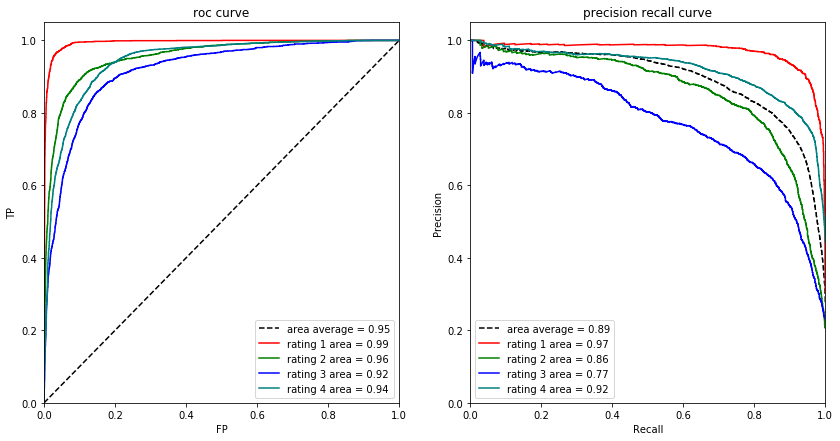

In [30]:
now = time.localtime()
print("%02d:%02d:%02d"%(now.tm_hour, now.tm_min, now.tm_sec))
plot_multiclass_roc_prc(svm, X_scaled_dev, y_dev)

In [29]:
submission = pd.DataFrame({"id": idx, "prediction": svm_pred_test})
print('save submission')
submission.to_csv("./submission/eda_16_8_8_2_submission.csv", index=False)
submission.head()

save submission


,id,prediction
0,3,4
1,6,4
2,9,3
3,11,4
4,12,4


In [ ]:
svmsmote = SVMSMOTE(sampling_strategy='not majority', k_neighbors=4, svm_estimator=SVC(C=10), n_jobs=-1)
X_samp, y_samp = svmsmote.fit_sample(X_scaled_train, y)
print('sampling finish')
svm = OneVsRestClassifier(BaggingClassifier(SVC(C = 10, gamma='auto', probability=True), 
                                            max_samples=1.0 / n_estimators, 
                                            n_estimators=n_estimators),
                          n_jobs=-1)
svmresult = svm.fit(X_samp, y_samp)
print('fitting finish')
svmpredtrain = svmresult.predict(X_samp)
svmpreddev = svmresult.predict(X_scaled_dev)

print("kappa\ntrain : %f\tdev : %f"% (metric.quadratic_weighted_kappa(y_samp, svmpredtrain), \
                                      metric.quadratic_weighted_kappa(y_dev, svmpreddev)))

print("rmse\ntrain : %f\tdev : %f"% (mean_squared_error(y_samp, svmpredtrain)**0.5, \
                                     mean_squared_error(y_dev, svmpreddev)**0.5))

print('\nconfusion_matrix : %d개중 %d개를 틀림\n'%(len(y_dev), len(np.where(svmpreddev!=y_dev)[0])), \
      confusion_matrix(y_dev, svmpreddev))
print('\nclassification_report :\n', classification_report(y_dev, svmpreddev))

plot_multiclass_roc_prc(svmresult, X_scaled_dev, y_dev)